In [3]:
import sys
import os
import pandas as pd
import numpy as np

import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import download
import warnings
import nltk

warnings.filterwarnings(action = 'ignore')

import gensim 
from gensim.models import Word2Vec
from curses.ascii import isalpha
from gensim.models import KeyedVectors


from nltk.corpus import stopwords
spanish_stop_words = set(stopwords.words('spanish'))


import seaborn as sns
import matplotlib.pyplot as plt

# Import adjustText, initialize list of texts
from adjustText import adjust_text

from sklearn.manifold import TSNE

# Para calcular similitud de vectores de misma longitud
from gensim.matutils import unitvec

# Stemmer de palabras
from nltk.stem.snowball import SnowballStemmer

snowballstemmer = SnowballStemmer('spanish')

# Categorias relevantes
variables = ["macroeconomia","sostenibilidad","regulaciones","reputacion","alianzas","innovacion"]

In [5]:
# cambiar url para leer los datos de otro subfolder con path relativo
# os.chdir('../')

# Descarga de archivos nltk necesarios para modelar, descargue todo
# download()

In [6]:
noticias = pd.read_csv('../datos/noticias.csv')
clientes_noticias = pd.read_csv('../datos/clientes_noticias.csv')

# Funciones

In [7]:
def clean_text_news(df):
    df['len_titular'] = df['news_title'].apply(lambda x: len(x))
    df['len_content'] = df['news_text_content'].apply(lambda x: len(x))
    return df
    
def create_tokenization(x):
    data = []
    for j in word_tokenize(x,language='spanish'):
        term = j.lower()

        if term.isalpha() and not term in spanish_stop_words:
            #term = snowballstemmer.stem(term)
            data.append(term)
        
    return data

def document_vector(word2vec_model, doc, vocab):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in vocab]
    return np.mean(word2vec_model.wv[doc], axis=0)

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(vocab, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc,vocab):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if has_vector_representation(vocab,doc)]

    corpus = [doc for doc in corpus if has_vector_representation(vocab,doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def similitud(v1,v2):
    """
        Esta funcion calcula la similitud de dos vectores de misma longitud

        Inputs:
            v1: vector 1
            v2: vector 2
        
        Output: float

            Similitud de vectores

    """
    return np.dot(unitvec(v1), unitvec(v2))

def df_categoria_noticia(df_noticas,lista_temas,modelo,vector_promedio_noticias):

    diccionario_resultados = {}
    for variable in lista_temas:
        vector_tema = modelo.wv[variable]
        similitud_noticias = [similitud(a,vector_tema) for a in vector_promedio_noticias]
        diccionario_resultados[variable] = similitud_noticias

    resultados_temas = pd.DataFrame(diccionario_resultados)
    resultados_temas['Categoria'] = resultados_temas.idxmax(axis=1)
    resultados_temas['Similitud'] = resultados_temas.max(axis=1)

    # df_salida = pd.concat([df_noticas,resultados_temas[['Categoria']]],axis=1)
    df_salida = pd.concat([df_noticas,resultados_temas[['Categoria','Similitud']]],axis=1)

    return df_salida

def preprocessing_noticias(df):

    print(df.shape)
    df = df[df['news_text_content']!=' '].reset_index(drop=True).copy()
    print(df.shape)
    df = df.drop_duplicates()
    print(df.shape)
    data = df['news_text_content'].apply(create_tokenization)
    # data_titulas = df['news_title'].apply(create_tokenization)
    
    return [df, data]

def matrix_by_new(df,model, vocab, vector_size, output_name = None, run = False, save = False):

    if run:
        new_mean_vector = []
        for doc in df: # append the vector for each document
            try:
                output = document_vector(model, doc, vocab=vocab)
            except:
                output = np.zeros(vector_size)
            new_mean_vector.append(output)

        mean_vector = np.array(new_mean_vector) # list to array
        if save:
            with open(output_name+'.npy', 'wb') as f:
                np.save(f, new_mean_vector)

    else:
        mean_vector = np.load('array_mean_vector_model.npy')
        
    return mean_vector

In [8]:
data = preprocessing_noticias(noticias)

(23377, 6)
(23346, 6)
(23346, 6)


In [9]:
# from time import time  # To time our operations

run_model = False
path_model = "models/Model/word2vec.model"
# semilla = 2022
vector_size = 100

if run_model:

    model = Word2Vec(data[1],min_count=1,
                     window=5,
                     vector_size=vector_size,
                    #  sample=6e-5, 
                    #  alpha=0.03, 
                    #  min_alpha=0.0007, 
                    #  hs = 0,
                    #  negative=20,
                     workers=cores-1,
                    #  seed = semilla,
                     sg = 1)
    
    # model.save(path_model)

else:
    model = Word2Vec.load(path_model)

vocab = list(model.wv.index_to_key)                                     

In [10]:
sims = model.wv.most_similar('innovacion', topn=20)
sims

[('tecnologia', 0.8312691450119019),
 ('sncti', 0.8216502666473389),
 ('iccti', 0.8028162121772766),
 ('proinnovate', 0.7993803024291992),
 ('senescyt', 0.7975841760635376),
 ('micitt', 0.7975763082504272),
 ('jannixia', 0.7932529449462891),
 ('ciencia', 0.7913185954093933),
 ('emprendimiento', 0.7911211252212524),
 ('fusionando', 0.7889145016670227),
 ('ctel', 0.7845596075057983),
 ('tecnologica', 0.7810786962509155),
 ('greentech', 0.7798160910606384),
 ('macrozona', 0.7785157561302185),
 ('mincyt', 0.7744529843330383),
 ('macrotendencias', 0.7741804718971252),
 ('habilitadores', 0.7730867266654968),
 ('addotar', 0.7724708318710327),
 ('ctci', 0.77205491065979),
 ('emprendedurismo', 0.769287109375)]

In [11]:
# configuracion
run_matrix = False

vector_mean = matrix_by_new(df=data[1], vocab=vocab, model=model, run=run_matrix, vector_size=vector_size)
salida_categorias = df_categoria_noticia(df_noticas=data[0],lista_temas=variables,modelo=model,vector_promedio_noticias=vector_mean)

In [12]:
salida_categorias.groupby('Categoria').mean()['Similitud']

Categoria
alianzas          0.587121
innovacion        0.594741
macroeconomia     0.587056
regulaciones      0.576101
reputacion        0.523784
sostenibilidad    0.515789
Name: Similitud, dtype: float64

In [13]:
salida_categorias.sort_values(['Categoria','Similitud'],ascending = False, inplace=True)
muestra = salida_categorias.groupby('Categoria').head(100)
muestra['Categoria'].value_counts()
# muestra.to_csv('muestra_categorias.csv')

sostenibilidad    100
reputacion        100
regulaciones      100
macroeconomia     100
innovacion        100
alianzas          100
Name: Categoria, dtype: int64

In [14]:
muestra.groupby('Categoria').mean()['Similitud']

Categoria
alianzas          0.668441
innovacion        0.700494
macroeconomia     0.649634
regulaciones      0.644326
reputacion        0.559659
sostenibilidad    0.630593
Name: Similitud, dtype: float64

In [15]:
original_muestra = pd.read_csv('muestra_categorias_original.csv',index_col='Unnamed: 0')
original_muestra.groupby('Categoria').mean()['Similitud']
original_muestra['val_cat'] = original_muestra['news_url_absolute'].apply(lambda x: x.split('/')[3])

In [16]:
# nota
# 2022

val = original_muestra[original_muestra['Categoria']=='macroeconomia']
val[val['val_cat']=='nota']

,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content,Categoria,Similitud,val_cat
17649,news77900,https://www.letrap.com.ar/nota/2022-8-5-10-32-...,2022-07-30,2022-08-14,"Un ortodoxo con pasado en Lavagna, el vice ...",Con la designacion de Gabriel Rubinstein frent...,macroeconomia,0.688243,nota
9273,news45579,https://www.eldiariodelarepublica.com/nota/202...,2022-07-15,2022-07-30,"Batakis se reunio con la titular del FMI, que ...","La ministra de Economia, Silvina Batakis, mant...",macroeconomia,0.685096,nota
9537,news46743,https://www.letrap.com.ar/nota/2022-7-16-17-47...,2022-07-15,2022-07-30,"Entre Guzman y su sucesora, Pesce no duda: ""Es...",Las criticas que antes resonaban por los pasil...,macroeconomia,0.664930,nota


# Classifier models

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.model_selection import train_test_split

In [18]:
x = muestra['news_text_content']
y = muestra['Categoria']

print(x.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=2022)

(600,) (600,)


In [19]:
from time import time


nb = Pipeline([('vect',CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',MultinomialNB())])

nb.fit(X_train, y_train)            

from sklearn.metrics import classification_report, accuracy_score

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test,y_pred,target_names=variables))

accuracy 0.8111111111111111
                precision    recall  f1-score   support

 macroeconomia       1.00      0.58      0.73        31
sostenibilidad       0.71      1.00      0.83        27
  regulaciones       0.59      1.00      0.74        29
    reputacion       1.00      0.46      0.63        37
      alianzas       1.00      0.97      0.98        32
    innovacion       0.89      1.00      0.94        24

      accuracy                           0.81       180
     macro avg       0.87      0.83      0.81       180
  weighted avg       0.88      0.81      0.80       180



In [20]:
salida_categorias['nb_categoria'] = nb.predict(salida_categorias['news_text_content'])

In [21]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect',CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf',SGDClassifier(loss = 'hinge', alpha = 1e-3, random_state=2022, max_iter=5, tol = None))])

sgd.fit(X_train,y_train)            

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test,y_pred,target_names=variables))

accuracy 0.9777777777777777
                precision    recall  f1-score   support

 macroeconomia       1.00      0.90      0.95        31
sostenibilidad       0.96      1.00      0.98        27
  regulaciones       1.00      0.97      0.98        29
    reputacion       1.00      1.00      1.00        37
      alianzas       1.00      1.00      1.00        32
    innovacion       0.89      1.00      0.94        24

      accuracy                           0.98       180
     macro avg       0.98      0.98      0.98       180
  weighted avg       0.98      0.98      0.98       180



In [22]:
salida_categorias['sgd_categoria'] = sgd.predict(salida_categorias['news_text_content'])

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect',CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf',LogisticRegression(n_jobs=1, C= 1e5))])

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test,y_pred,target_names=variables))

accuracy 0.9833333333333333
                precision    recall  f1-score   support

 macroeconomia       0.97      0.97      0.97        31
sostenibilidad       0.96      1.00      0.98        27
  regulaciones       1.00      0.97      0.98        29
    reputacion       1.00      1.00      1.00        37
      alianzas       1.00      1.00      1.00        32
    innovacion       0.96      0.96      0.96        24

      accuracy                           0.98       180
     macro avg       0.98      0.98      0.98       180
  weighted avg       0.98      0.98      0.98       180



In [24]:
salida_categorias['logreg_categoria'] = logreg.predict(salida_categorias['news_text_content'])

In [25]:
# logistic regression with Word2vec embedding

train, test = train_test_split(muestra, test_size=0.3, random_state = 2022)

test_tokenized = data[1][test.index]
train_tokenized = data[1][train.index]

X_train_word_average = vector_mean[train.index]
X_test_word_average = vector_mean[test.index]

In [26]:
logreg_w2v = LogisticRegression(n_jobs=1, C= 1e5)
logreg_w2v = logreg_w2v.fit(X_train_word_average,train.Categoria)

y_pred = logreg_w2v.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred,test.Categoria))
print(classification_report(test.Categoria,y_pred,target_names=variables))

accuracy 1.0
                precision    recall  f1-score   support

 macroeconomia       1.00      1.00      1.00        31
sostenibilidad       1.00      1.00      1.00        27
  regulaciones       1.00      1.00      1.00        29
    reputacion       1.00      1.00      1.00        37
      alianzas       1.00      1.00      1.00        32
    innovacion       1.00      1.00      1.00        24

      accuracy                           1.00       180
     macro avg       1.00      1.00      1.00       180
  weighted avg       1.00      1.00      1.00       180



In [30]:
salida_categorias['logreg_w2v_categoria'] = logreg_w2v.predict(vector_mean[salida_categorias.index])

In [32]:
salida_categorias.columns

Index(['news_id', 'news_url_absolute', 'news_init_date', 'news_final_date',
       'news_title', 'news_text_content', 'Categoria', 'Similitud',
       'nb_categoria', 'sgd_categoria', 'logreg_categoria',
       'logreg_w2v_categoria'],
      dtype='object')

In [41]:
pd.crosstab(salida_categorias.sgd_categoria, salida_categorias.nb_categoria)

nb_categoria,alianzas,innovacion,macroeconomia,regulaciones,reputacion,sostenibilidad
sgd_categoria,,,,,,
alianzas,1218,1081,1585,0,1,183
innovacion,0,1383,165,0,0,1
macroeconomia,0,0,1282,0,0,0
regulaciones,2,56,1795,309,1,158
reputacion,14,324,4542,1,2396,101
sostenibilidad,5,871,2965,0,0,2907


In [47]:
salida_categorias.groupby('sgd_categoria').mean()

sgd_categoria
alianzas          0.596597
innovacion        0.635724
macroeconomia     0.608505
regulaciones      0.598217
reputacion        0.553899
sostenibilidad    0.589281
Name: Similitud, dtype: float64

In [75]:
from sklearn.metrics.pairwise import cosine_similarity

promedio_similitud_categorias = {}

lista_variables = ['nb_categoria', 'sgd_categoria', 'logreg_categoria','logreg_w2v_categoria']

for modelo in lista_variables:

    promedio_similitud_categorias[modelo] = {}

    for categoria in variables:
        indices = salida_categorias[salida_categorias[modelo]==categoria].index
        vectores_noticias = vector_mean[indices]
        similitudes = cosine_similarity(vectores_noticias,vectores_noticias)
        similitudes_prom = [sim.mean() for sim in similitudes]
        promedio_similitud_categorias[modelo][categoria] = np.array(similitudes_prom).mean()
    
    promedio_similitud_categorias[modelo]["prom_general"] = np.array(list((promedio_similitud_categorias[modelo].values()))).mean()

In [87]:
mayor = np.zeros(1)
var_modelo = None

for modelo in promedio_similitud_categorias.keys():

    nuevo = round(promedio_similitud_categorias[modelo]['prom_general'],3)

    print(f"Promedio general para {modelo} %s" % nuevo)
    if nuevo>mayor:
        mayor = nuevo
        var_modelo = modelo

print(str(mayor), var_modelo)

Promedio general para nb_categoria 0.863
Promedio general para sgd_categoria 0.886
Promedio general para logreg_categoria 0.89
Promedio general para logreg_w2v_categoria 0.885
0.89 logreg_categoria


In [94]:
salida_categorias['logreg_categoria'].value_counts()

reputacion        7976
regulaciones      4561
alianzas          4227
sostenibilidad    3589
innovacion        1557
macroeconomia     1436
Name: logreg_categoria, dtype: int64

In [96]:
salida_categorias.columns

Index(['news_id', 'news_url_absolute', 'news_init_date', 'news_final_date',
       'news_title', 'news_text_content', 'Categoria', 'Similitud',
       'nb_categoria', 'sgd_categoria', 'logreg_categoria',
       'logreg_w2v_categoria'],
      dtype='object')

In [99]:
# salida_categorias[salida_categorias['logreg_categoria'].isin(['macroeconomia','innovacion'])][['logreg_categoria','news_url_absolute']].to_csv("macro_reg.csv")
salida_categorias[salida_categorias['logreg_categoria'].isin(['regulaciones','reputacion'])][['logreg_categoria','news_url_absolute']].to_csv("sos_ali.csv")

In [100]:
cruce_participacion = salida_categorias[['news_id','news_url_absolute','logreg_categoria']]
cruce_participacion.to_csv('../categoiras.csv',index=False)

# TSNE 

In [43]:
indices = salida_categorias[salida_categorias['sgd_categoria']=='macroeconomia'].copy().reset_index()['index']
indices = indices.tolist()

In [44]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 3)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(vector_mean[indices])

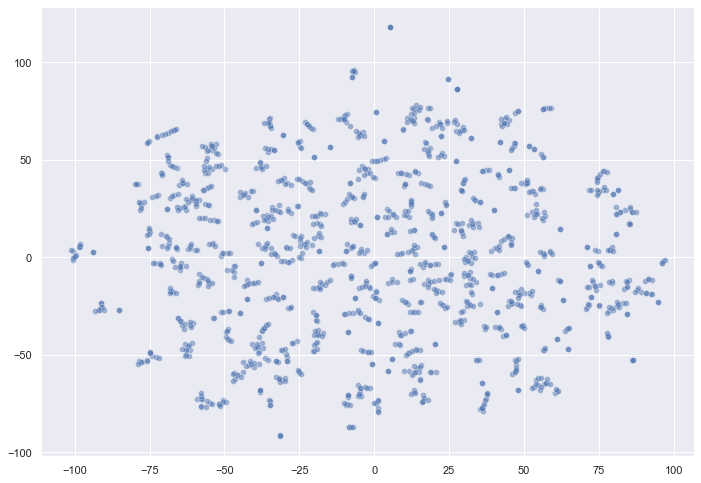

In [45]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

plt.show()

In [ ]:
id = 1550
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model2.wv[word] for word in data[id] if word in vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in data[id] if word in vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 3)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
words_to_plot = list(np.arange(0, df.shape[0], 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

noti_categorias = salida_categorias[variables]

corr = noti_categorias.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 800, 80)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()
